In [1]:
import numpy as np
import rasterio as rio
import geopandas as gpd
from rasterio.plot import show
import os
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo import osr
from fiona.crs import from_epsg
from shapely.geometry import box
from rasterio.mask import mask
import warnings
warnings.filterwarnings('ignore')

In [2]:
# User inputs
ip_dir = 'LC08_L1TP_140043_20180109_20180119_01_T1'
tir_band_num = int(10)
if tir_band_num!=10 and tir_band_num!=11:
    raise Exception("TIR band number in Landsat 8 are 10 and 11")

jcf_shp = gpd.read_file('jcf_utm.shp')
#xmin, ymin, xmax, ymax = 0, 0, 0, 0         # For manual AOI assignment instead of using external vector file

In [3]:
def RasClip_extent_manual(ras, xmin, ymin, xmax, ymax, op_file_name):
    
    bbox = box(xmin, ymin, xmax, ymax)
    coords = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    coords = coords.to_crs(crs=ras.crs.data)
    minx = coords.bounds['minx'].min()
    miny = coords.bounds['miny'].min()
    maxx = coords.bounds['maxx'].max()
    maxy = coords.bounds['maxy'].max()

    aoi = [{'type': 'Polygon',
                   'coordinates': [[(minx,miny),
                                    (minx,maxy),
                                    (maxx,maxy),
                                    (maxx,miny),
                                    (minx,miny)]]}]
    
    # applying mask 
    clipped, transform = mask(ras, aoi, crop=True)
    
    # use original metadata
    meta = ras.meta.copy()
    # update the metadata with clipped image metadata
    meta.update({"transform": transform,
                 "height":clipped.shape[1],
                 "width":clipped.shape[2]})
    with rio.open(op_file_name, 'w', **meta) as dst:
        dst.write(clipped)
    return rio.open(op_file_name)

In [4]:
def RasClip_extent_vector(ras, vec, op_file_name):
    vec_wgs84 = vec.to_crs(4326)
    xmin = vec_wgs84.bounds['minx'].min()
    ymin = vec_wgs84.bounds['miny'].min()
    xmax = vec_wgs84.bounds['maxx'].max()
    ymax = vec_wgs84.bounds['maxy'].max()
    
    # Rest of the computation is same as Raster Clip by providing manual extent
    return RasClip_extent_manual(ras = ras, xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax, op_file_name = op_file_name)

In [5]:
def dn2temp(dir):
    i = j = 0
    files=os.listdir(dir)
    for file in files:
        
        # Getting the meta data
        if file.endswith("_MTL.txt"):
            i = i+1
            meta=[]
            meta_file = open(os.path.join(ip_dir, file),"r")
            meta = meta_file.readlines()
            meta_file.close()
        
        # Loading TIR data
        if file.endswith("_B" + str(tir_band_num) + ".TIF"):
            j = j+1
            tir_file = rio.open(os.path.join(ip_dir, file))
    
    # Checking the integrity of input files
    if i>1 or j>1:
        raise Exception("Multiple input files within the input directory")
    if i==0 or j==0:
        raise Exception("Unable to find input files")    
    
    global tir_clip
    tir_clip = RasClip_extent_vector(ras=tir_file, vec=jcf_shp, op_file_name='tir_clip.tif')
    # Similarly, user function 'RasClip_extent_manual' can also be used without having a vector file. 
    
    # Converting to an array for manipulations        
    tir = np.empty(shape=(tir_clip.shape))
    tir = tir_clip.read(1).astype(float)
    
    # Getting constants from meta data
    for line in meta:
        if 'RADIANCE_MULT_BAND_' + str(tir_band_num) in line:
            rad_mult = float(line.split('=')[1])
        if 'RADIANCE_ADD_BAND_' + str(tir_band_num) in line:
            rad_add = float(line.split('=')[1])
        if 'K1_CONSTANT_BAND_' + str(tir_band_num) in line:
            k1 = float(line.split('=')[1])
        if 'K2_CONSTANT_BAND_' + str(tir_band_num) in line:
            k2 = float(line.split('=')[1])
    
    # conversion to radiance and then to at-sensor brightness temp
    tir_rad = rad_add + (rad_mult*tir)
    denomin = np.log((k1/tir_rad)+1)
    temperature = (k2/denomin)-273.15  #to get result in celcius

    return temperature

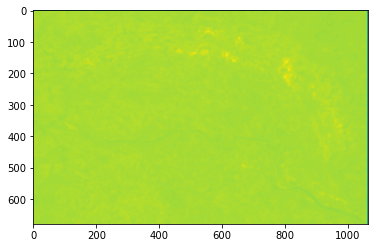

<AxesSubplot:>

In [6]:
temperature = dn2temp(ip_dir)
show(temperature)

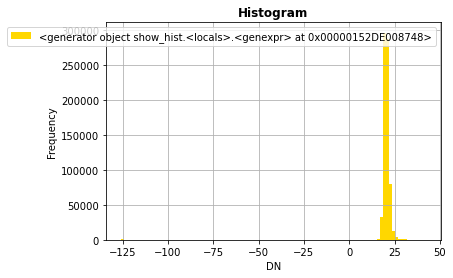

In [7]:
rio.plot.show_hist(temperature, bins=100)

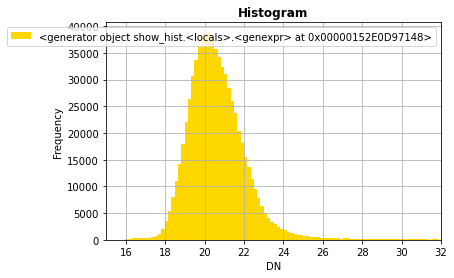

In [8]:
fig, ax = plt.subplots()
ax.set_xlim(15,32)   #To avoid faulty pixels
rio.plot.show_hist(temperature, bins=1000, ax=ax)

In [9]:
threshold = float(input("Enter the threshold value: "))

Enter the threshold value: 24


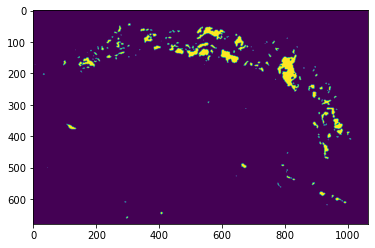

<AxesSubplot:>

In [10]:
temperature[np.where(temperature<threshold)] = 0        # can be np.nan 
temperature[np.where(temperature>=threshold)] = 1      #comment this line to get original temp values for the coal fire pixels
show(temperature)

In [11]:
def ReferencedGeocode(refRas, npArray,op_file_name):
    # Checking extension of the output file
    if op_file_name.endswith('.tif'):
        None
    else:
        op_file_name = op_file_name + '.tif'
        
    # Getting info for geocoding
    xmin, ymin, xmax, ymax = refRas.bounds
    nrows,ncols = np.shape(npArray)
    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    geotransform = xmin, xres, 0, ymax, 0, -yres 
    epsg_num = int(refRas.crs.data['init'].split(':')[1])
    
    # Applying the geocoding
    output_raster = gdal.GetDriverByName('GTiff').Create(op_file_name, ncols, nrows, 1, gdal.GDT_Float32)  
    output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
    srs = osr.SpatialReference()                 # Establish its coordinate encoding
    srs.ImportFromEPSG(epsg_num)
    output_raster.SetProjection(srs.ExportToWkt()) 
    output_raster.GetRasterBand(1).WriteArray(npArray)
    output_raster.FlushCache()
    
    return rio.open(op_file_name)

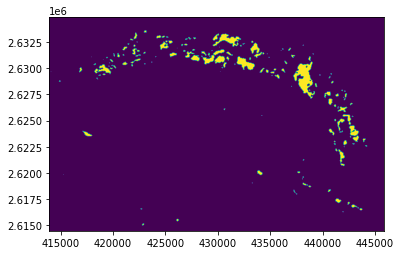

<AxesSubplot:>

In [12]:
coal_fire = ReferencedGeocode(tir_clip, temperature, "jcf")
show(coal_fire)

<b>Refernces</b><br>
Raster clip: https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html<br>
Projection: https://hatarilabs.com/ih-en/how-to-reproject-single-and-multiple-rasters-with-python-and-rasterio-tutorial